In [1]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


### Анализ рекламы развлекательного приложения Procrastinate Pro+.

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 
Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.
Выясним:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

В завершении исследования дадим рекомендации отделу маркетинга.

In [2]:
# Импортируем необходимые библиотеки, загрузим данные
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math
import copy

In [3]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

In [4]:
# Посмотрим на формат данных и их состав
visits.info()
# Выведем 5 первых строк данных таблицы visits
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [5]:
# Посмотрим на формат данных и их состав
orders.info()
# Выведем 5 первых строк данных таблицы orders
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [6]:
# Посмотрим на формат данных и их состав
costs.info()
# Выведем 5 первых строк данных таблицы costs
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Перед нами три датасета, которые раскрывают информацию о пользователях с данными об их регионе, устройстве, канале привлечения и началом-окончанием сессии, также кто из пользователей совершил покупки, когда и на какую сумму и затраты на рекламу, где указаны дата, рекламный канал и стоимость.

В таблице visits 309901 строк, orders - 40212, costs - 1800.
Типы данных: int, object, float

Перед началом исследования изменим наименование столбцов, проверим датасет на пропуски и дубликаты и изменим тип данных у столбцов с датой.

In [7]:
# Приведем наименование столбцов в таблицах к строчным буквам
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
display(visits.columns)
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
display(orders.columns)
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]
display(costs.columns)

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

Index(['dt', 'channel', 'costs'], dtype='object')

In [8]:
# Проверим наличие пропусков и дубликатов
print(visits.isna().sum())
print(visits.duplicated().sum())

print(orders.isna().sum())
print(orders.duplicated().sum())

print(costs.isna().sum())
print(costs.duplicated().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64
0
user_id     0
event_dt    0
revenue     0
dtype: int64
0
dt         0
channel    0
costs      0
dtype: int64
0


In [9]:
# Приведем столбцы с датами к верным типам данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

Пропусков и дубликатов в данных нет. Тип данных изменили. Можно приступать к исследованию.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [10]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

#### Составим профили пользователей. Найдем min/max дату привлечения пользователя.

In [18]:
# Получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [19]:
# Узнаем минимальную и максимальную даты привлечения пользователей 
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()

In [20]:
min_analysis_date

Timestamp('2019-05-01 00:00:00')

In [21]:
observation_date

Timestamp('2019-10-27 00:00:00')

Минимальная дата привлечения пользователей 1 мая 2019г.

Максимальная дата привлечения пользователей 27 октября 2019г.

#### Выясним из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

In [22]:
display(
    profiles.groupby('region')
    .agg({'user_id': 'count','payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.format({'payer': '{:.1%}'})
)

,user_id,payer
region,,
United States,100002,6.9%
Germany,14981,4.1%
UK,17575,4.0%
France,17450,3.8%


Пользователи приходят из США, Германии, Великобритании и Франции. Больше всего платящих пользователей приходят из США - 6,9%.

#### Узнаем какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.

In [23]:
display(
    profiles.groupby('device')
    .agg({'user_id': 'count','payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.format({'payer': '{:.1%}'})
)

,user_id,payer
device,,
Mac,30042,6.4%
iPhone,54479,6.2%
Android,35032,5.9%
PC,30455,5.0%


Среди пользователей iPhone больше всего клиентов, меньше со смартфонами на Android. Меньше пользователей заходят с компьютеров, как Mac (чуть больше), так и с РС. 

Однако больше всего покупок совершают с Mac (6,3%), чуть меньше через iPhone(6,2%). 5,8% пользователей смартфонов на android совершают покупки и 5% через РС. 

#### Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей.

In [24]:
display(
    profiles.groupby('channel')
    .agg({'user_id': 'count','payer': 'mean'})
    .sort_values(by='payer', ascending=False)
    .style.format({'payer': '{:.2%}'})
)

,user_id,payer
channel,,
FaceBoom,29144,12.20%
AdNonSense,3880,11.34%
lambdaMediaAds,2149,10.47%
TipTop,19561,9.60%
RocketSuperAds,4448,7.91%
WahooNetBanner,8553,5.30%
YRabbit,4312,3.83%
MediaTornado,4364,3.57%
LeapBob,8553,3.06%


Больше всего платящих клиентов пришло по каналу FaceBoom - 12,2%. Далее мы видим AdNonSensе - 11,34%,
lambdaMediaAds - 10,47%, TipTop - 9,6%.

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

#### Посчитаем общую сумму расходов на маркетинг.

In [25]:
# Вспомним таблицу costs
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [26]:
# Расчитаем общую сумму расходов на маркетинг
print('Общая сумма расходов на маркетинг', round(costs['costs'].sum(),1))

Общая сумма расходов на маркетинг 105497.3


#### Распределение трат по рекламным источникам.

In [27]:
display(
    costs.groupby('channel')
    .agg({'costs': 'sum'})
    .sort_values(by='costs', ascending=False)
)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Самые большие закупки рекламы идут через TipTop и FaceBoom: 54751 и 32445 соответственно. 

#### Построим график изменения расходов во времени (по неделям и месяцам) по каждому источнику.

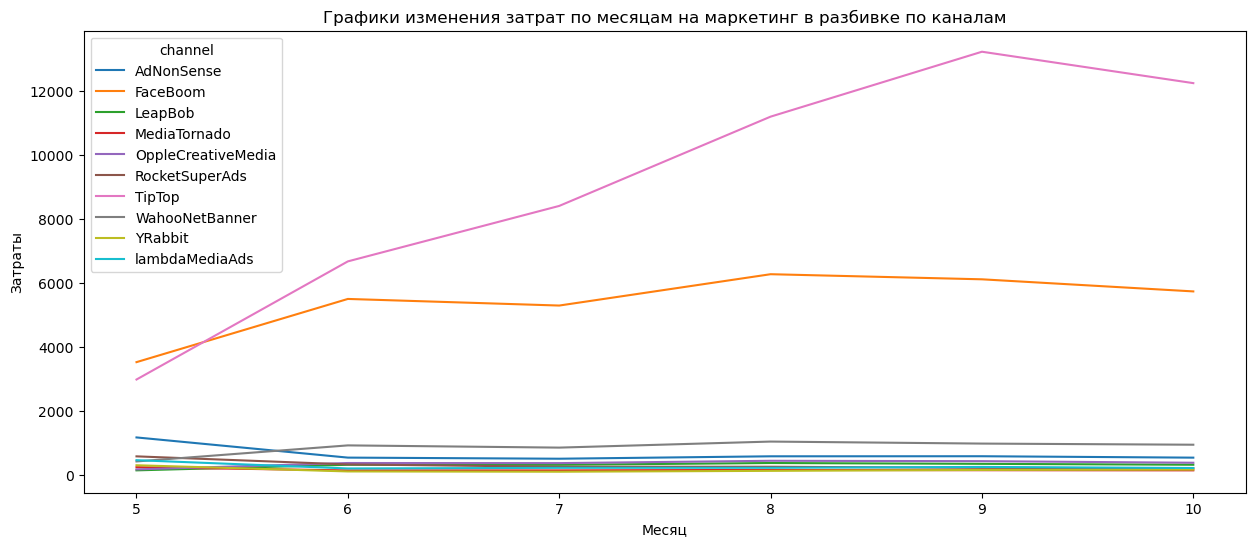

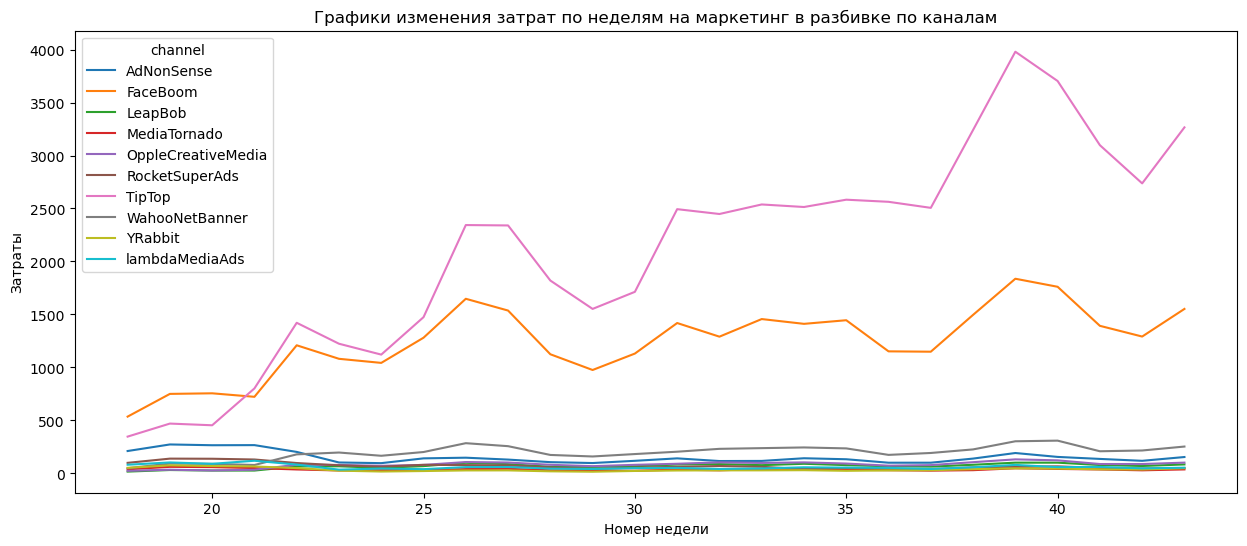

In [28]:
# Создадим столбец week с номером недели и month  с номером месяца
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month
# Сделаем две сводные таблицы для понедельного и помесячного графиков
changes_costs_week = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
changes_costs = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
# Построим графики
ax = changes_costs.plot(figsize=(15,6), legend=True)
plt.title('Графики изменения затрат по месяцам на маркетинг в разбивке по каналам')
plt.xlabel('Месяц')
plt.ylabel('Затраты')
ax = changes_costs_week.plot(figsize=(15,6), legend=True)
plt.title('Графики изменения затрат по неделям на маркетинг в разбивке по каналам')
plt.xlabel('Номер недели')
plt.ylabel('Затраты')
plt.show()

Две активные площадки: Tip Top и FaceBoom. Видим, что втечение полугода рекламный бюджет вырос в 6 раз. Большая его часть уходила за закупку рекламы через TipTop, в два раза меньше на рекламу через FaceBoom. На прочие каналы распределился очень малый бюджет равномерно во времени.

#### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [29]:
display(
    profiles.query('channel != "organic"').groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .sort_values(by='acquisition_cost', ascending=False)
    .style.format({'acquisition_cost': '{:.2f}'})
)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Самый догорой пользователь идет через площадку TioTop(2,8), далее FaceBoom (1,11) и AdNonSense(1,01).

In [30]:
# Cредний CAC на одного пользователя для всего проекта
profiles['acquisition_cost'].mean()

0.7032778251827625

#### Вывод

За полгода работы на рекламный бюджет было веделено 105497.3. Изучая графики мы видим, что практически с каждым месяцем бюджет рос. Половина бюджета была отдана на рекламу через площадку TipTop, однако мы видим что у площадки самое догорое привлечение пользователя - 2,8 за одного клиента, хотя процент платящих всего 9,6%. В то время как площадка FaceBoom показывает 12,2% платящих клиентов и стоимость привлечения одного компании обходится в 1,1. Также стоит отметить, что САС по площадке TipTop в разы превышает средную стоимость клиента по всему проекту.

### Оценим окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

#### Окупаемость рекламы

In [31]:
# Зададим горизонт анализа
horizon_days = 14   

In [32]:
# Исключим пользователей с органического трафика
profiles = profiles.query('channel != "organic"') 

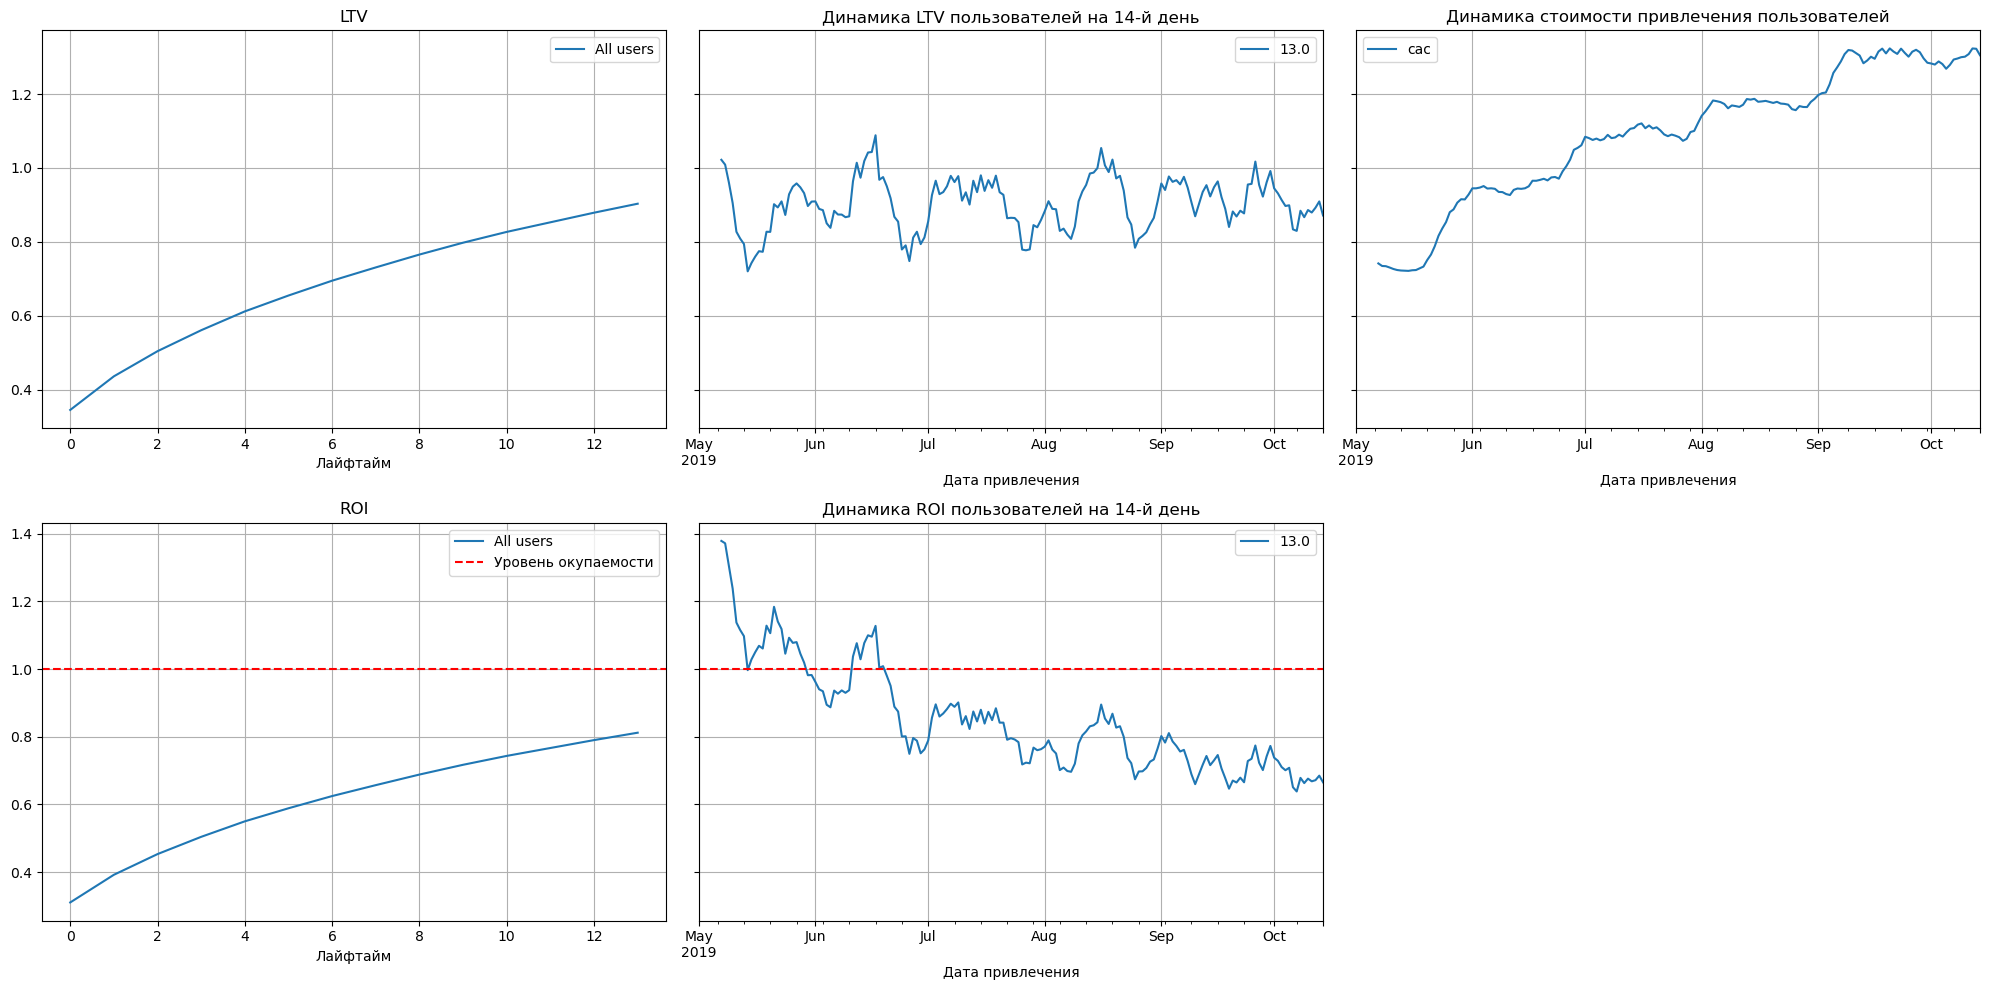

In [33]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Видим стабильное поведение клиентов (по параметру LTV), что готовит о хорошем качестве траффика. Но стоимость привлечения клиента растет, а окупаеммость, к сожалению, падает. С июня месяца частично, а с июля реклама полностью не окупается. Как мы знаем с мая по июнь большую часть рекламного бюджета направляли на рекламу через FaceBoom - что окупалось, а с июля выбор сделали в сторону площадки TipTop, где высокая стоимость клиента и недостаточно высокий процент покупок. 

#### Конверсия пользователей и динамика её изменения.

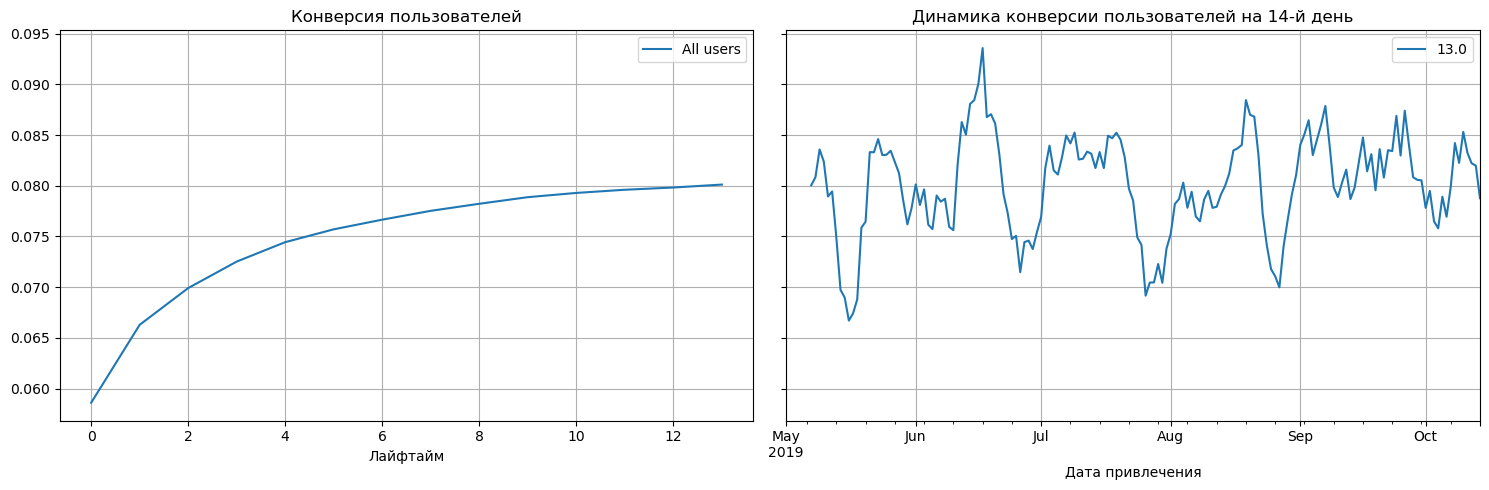

In [34]:
# смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

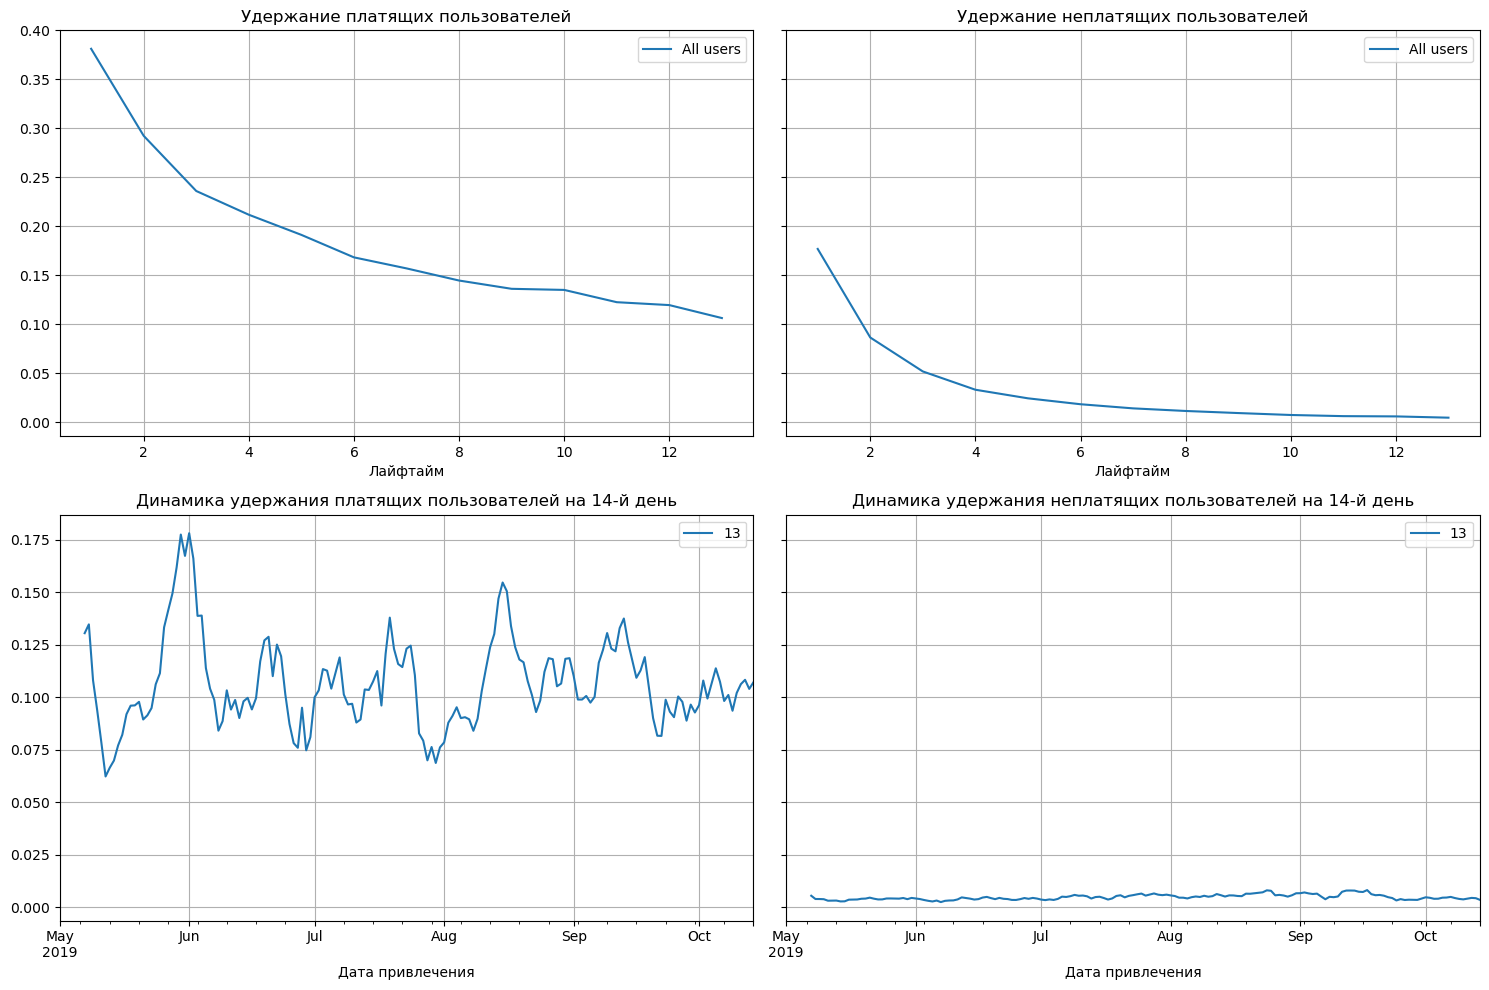

In [35]:
# смотрим удержание 
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Видим, что конверсия растет: идет активное привлечение клиентов. По графику динамики конверсии мы видим сезонность. С удержанием клиентов тоже все в порядке - нет резких спадов. В динамике также видна сезонность. 

#### Конверсия и окупаемость рекламы с разбивкой по устройствам.

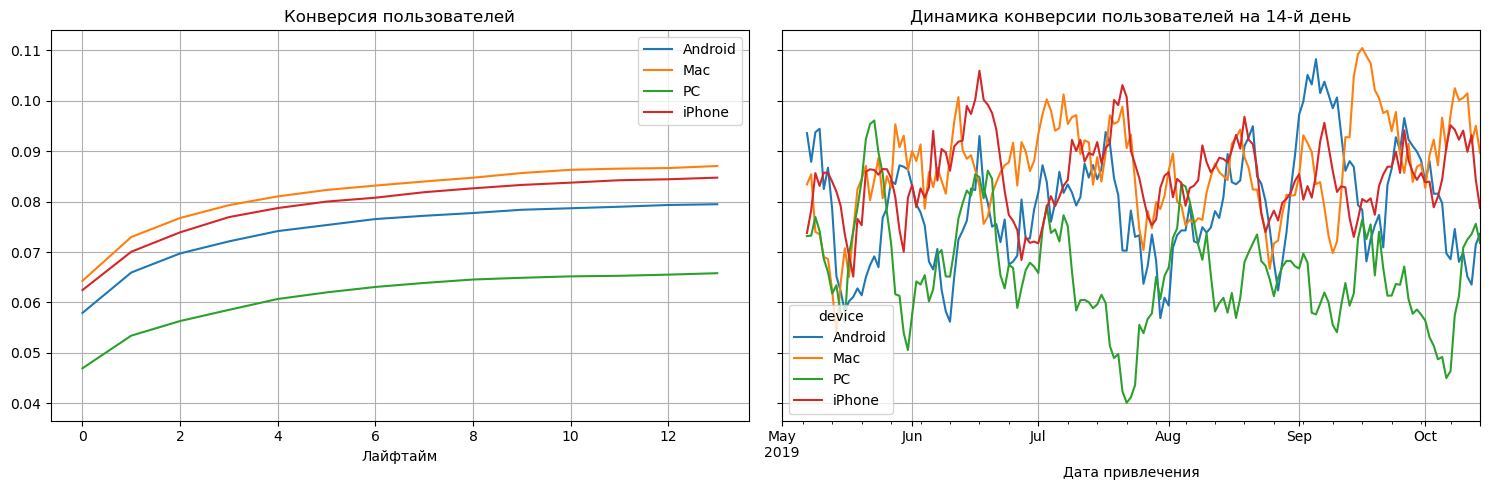

In [36]:
#Смотрим конверсию по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Хорошую конверсию нам показывают Mac и iPhone. В динамике мы видим, что Mac лидирует, а вот РС явно уступает.

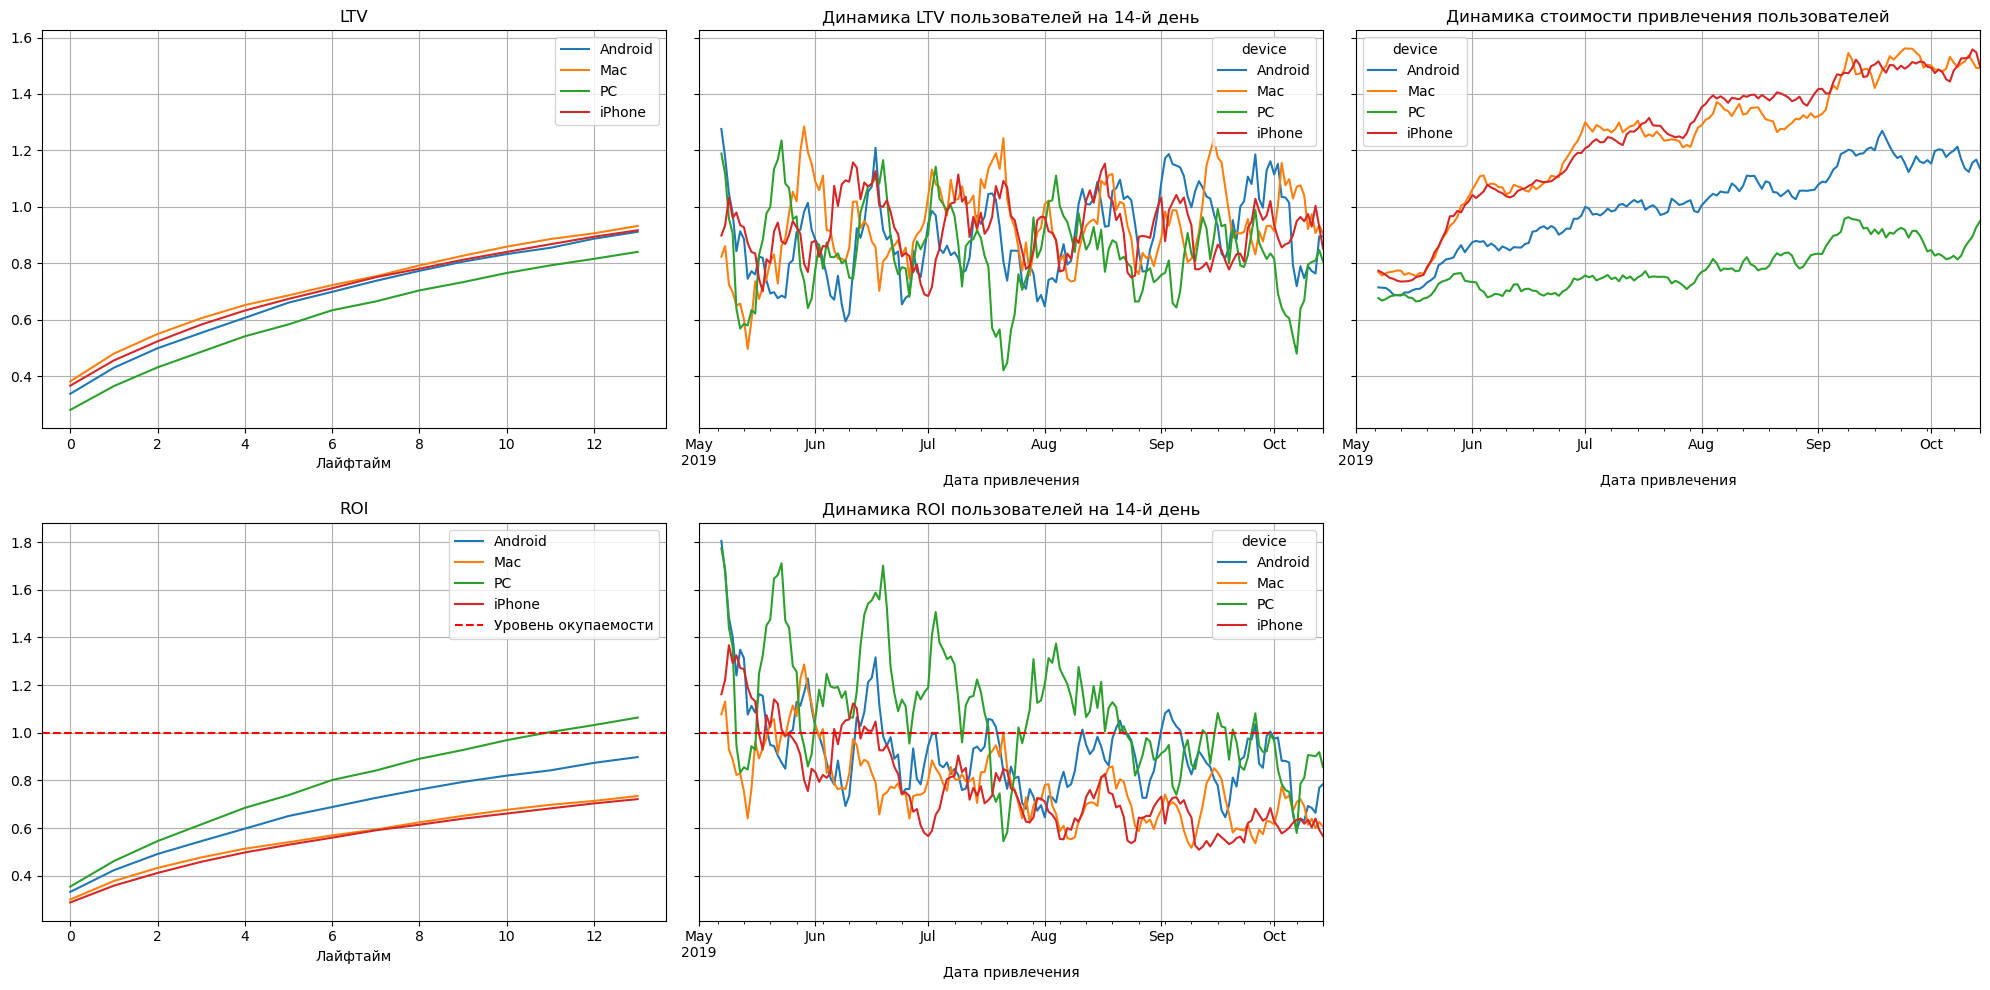

In [37]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['device']

# считаем LTV, ROI и САС с разбивкой по устройствам.
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Хорошую окупаемость имеют покупки через PC. Хотя мы видим, что рекламного бюджета на закупку рекламы на PC идет меньше всего. Намного больше средств направлено на Mac и iPhone - но показатели окупаемости у них очень низкие, и с каждым месяцем все ниже. Посмотрим на удержание по устройстам.

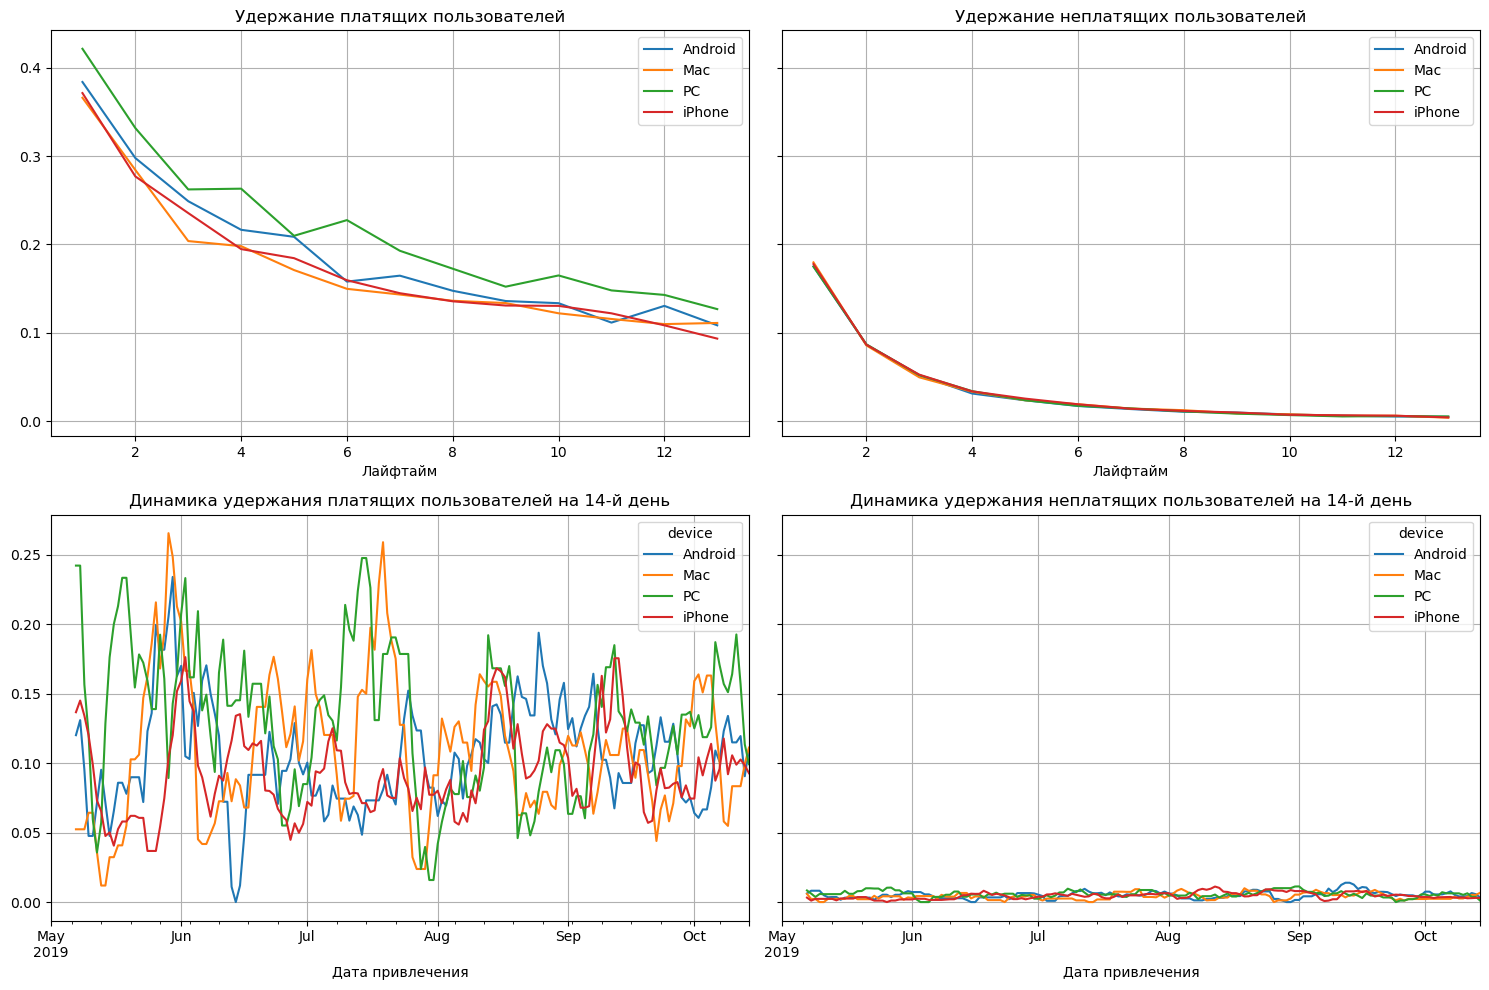

In [38]:
# смотрим удержание с разбивкой по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержания клиентов на РС в разы больше, чем с других устройств. Mac и iPhone показывают схожие результаты. В динамине iPhone показывает себя хуже, чем Mac. Возможно дело в адаптации для браузера Safari.

#### Конверсия и окупаемость рекламы с разбивкой по странам.

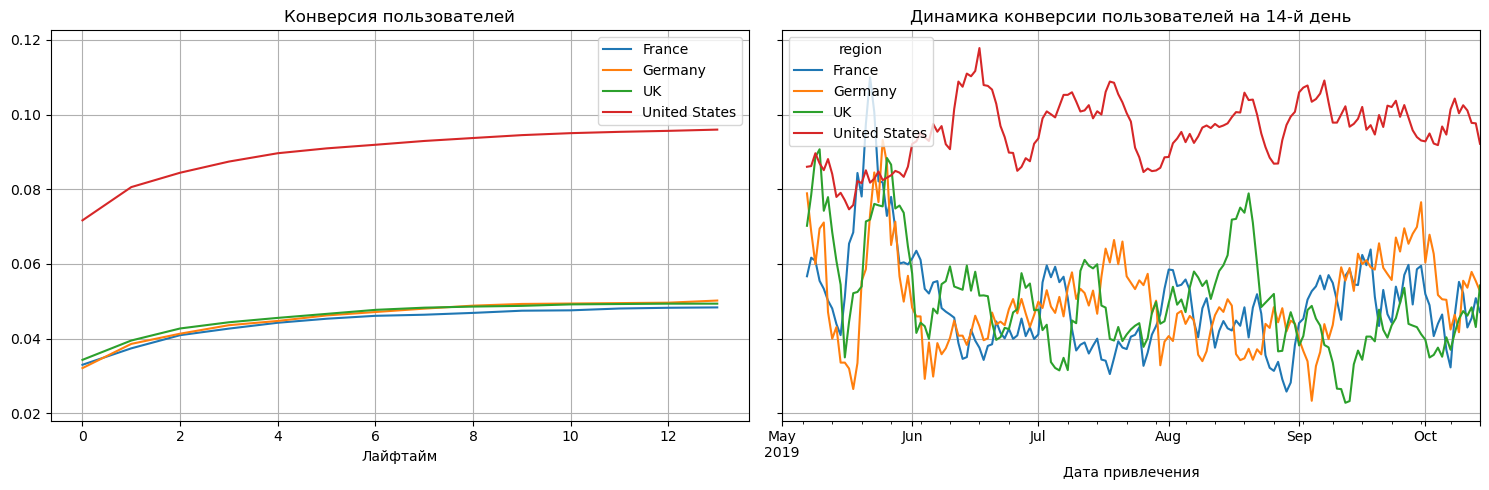

In [39]:
#Смотрим конверсию по регионам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Видим сильное преобладание США. Европейские страны показывают схожие результаты.

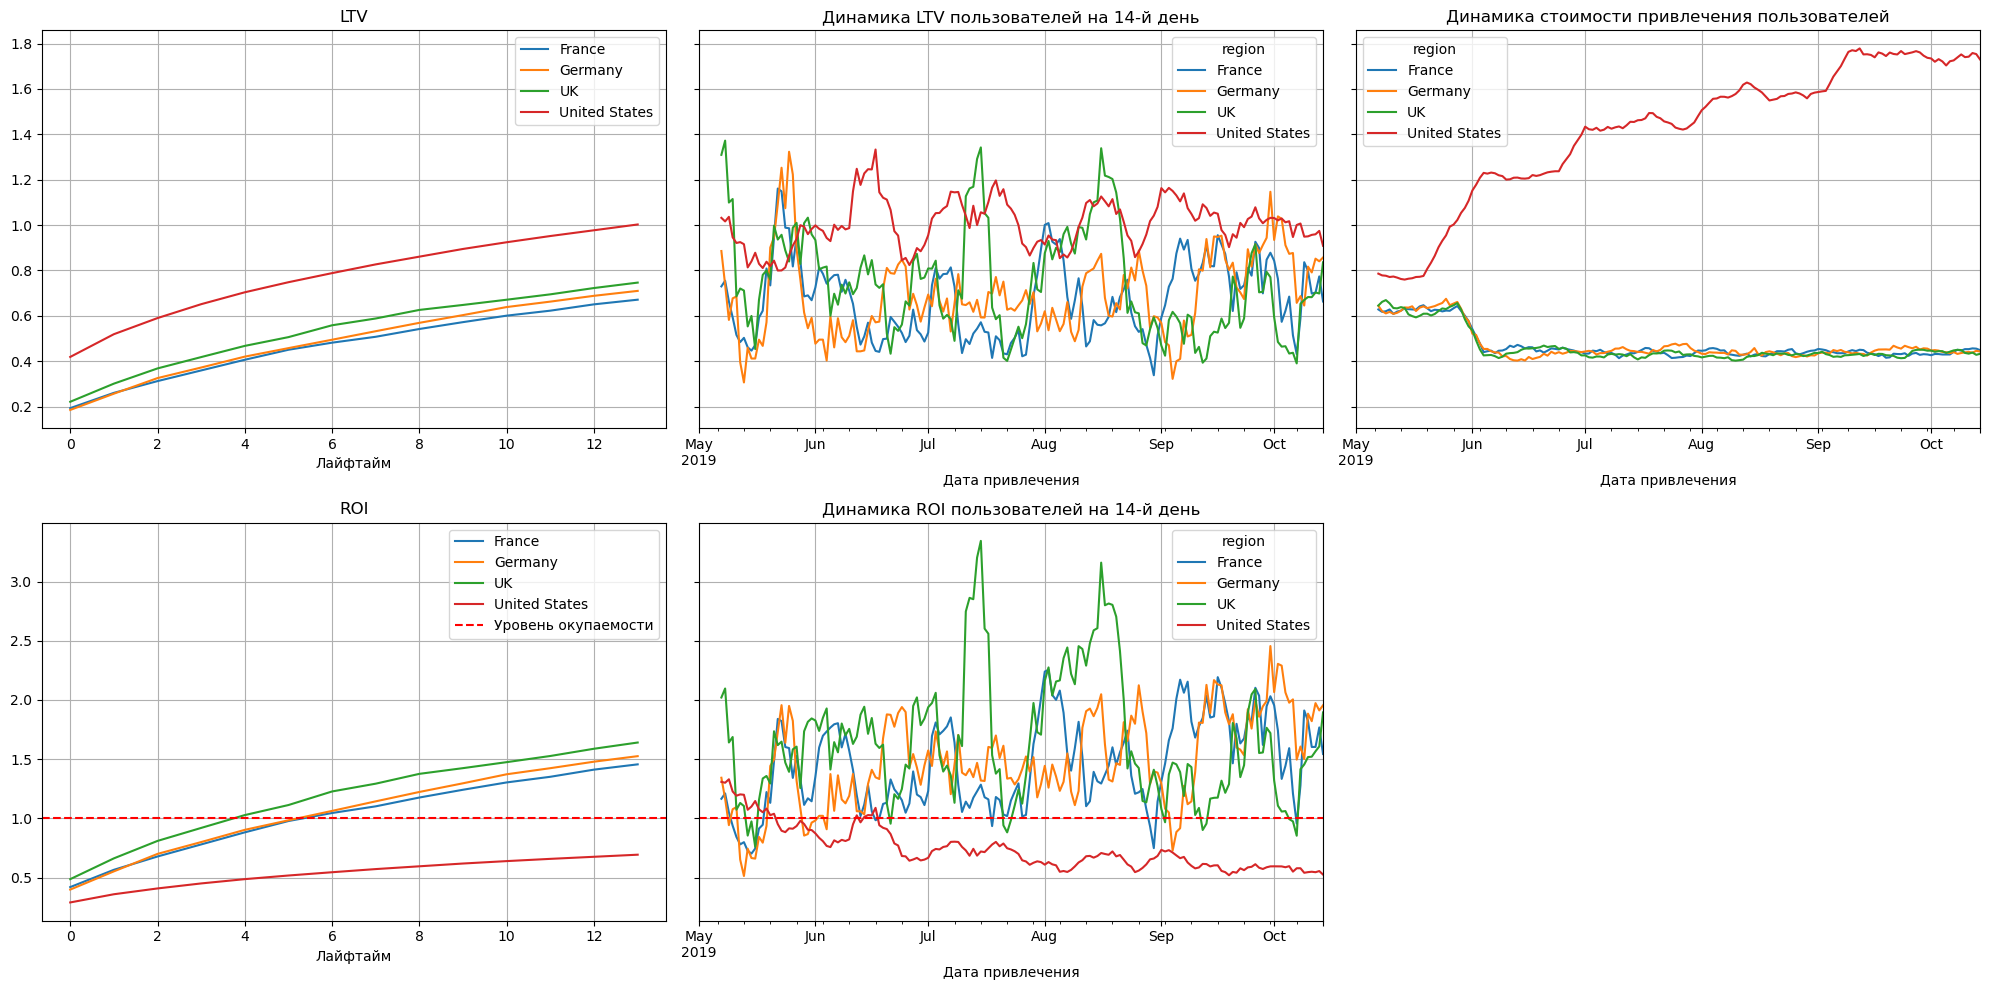

In [40]:
# смотрим окупаемость с разбивкой по регионам
dimensions = ['region']

# считаем LTV, ROI и САС с разбивкой по регионам.
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Пользователи из США показывают хорошую заинтересованность, частое пользование приложением - намного выше чем европейские пользователи. В октябре 80% рекламы таргетировалась на США, к сожалению как октябрьская, так и вся реклама с июня месяца на США не окупается, в отличие от всей европейской, которая показывает окупаемость. 

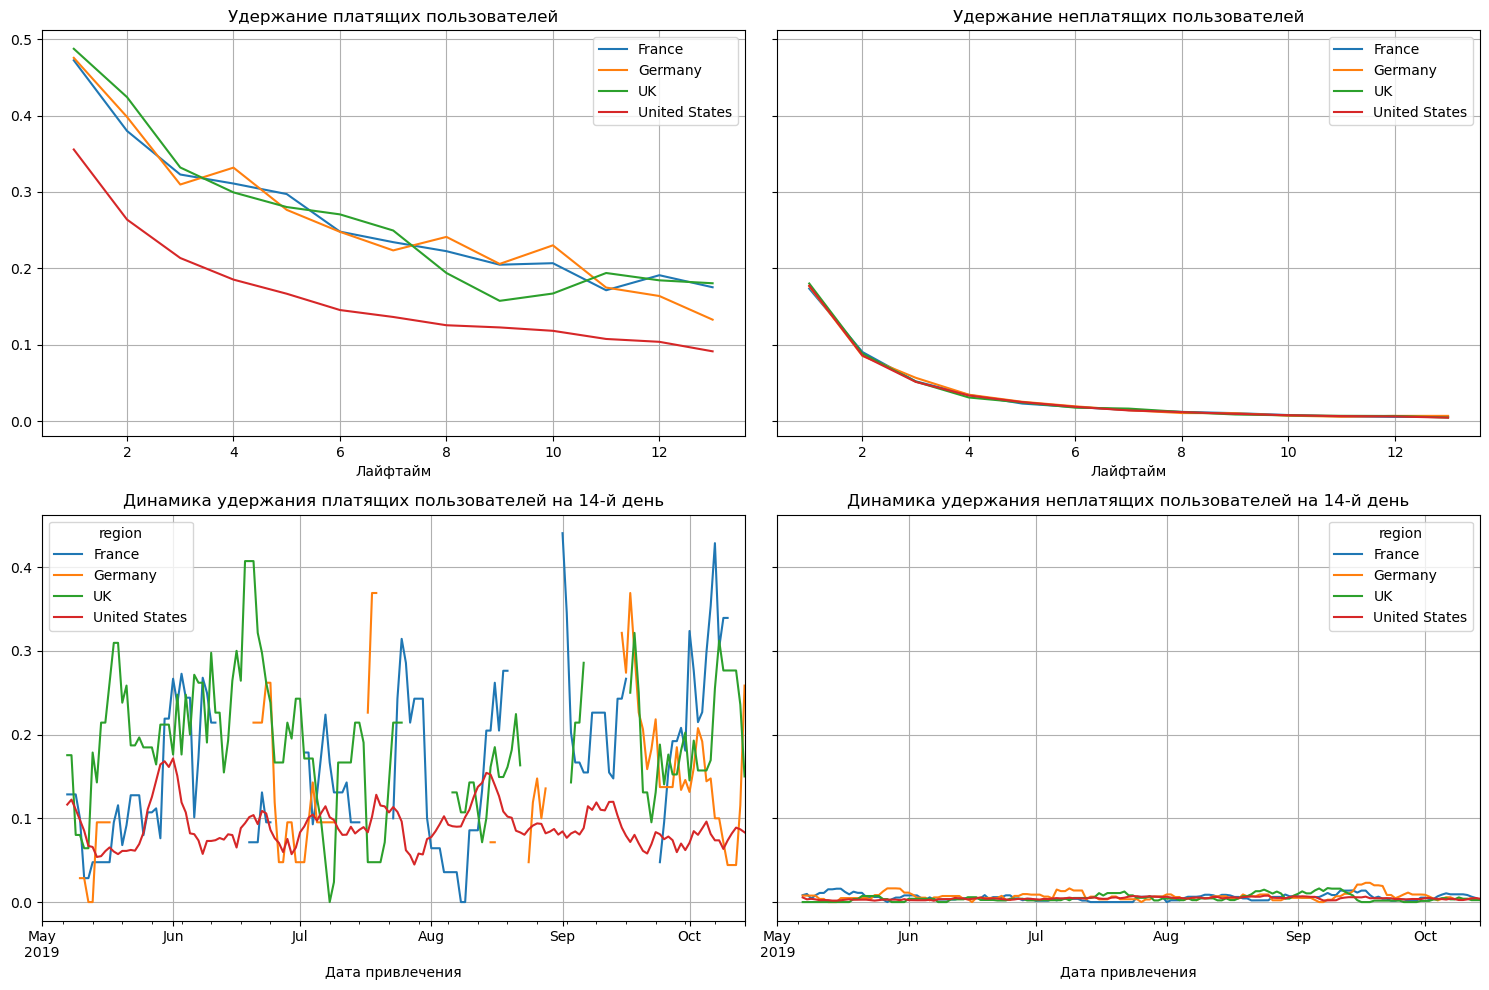

In [41]:
# смотрим удержание с разбивкой по регионам
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Несмотря на высокую конверсию и заинтересованность, клиенты из США очень плохо удерживаются. Очевидно в этом и кроется основная проблема.

In [42]:
#Посмотрим сколько пользоватей Apple в США
profiles.query('region == "United States"').groupby('device').agg({'user_id':'count'})

,user_id
device,
Android,12436
Mac,15424
PC,6421
iPhone,27548


In [43]:
#Посмотрим сколько пользоватей Apple в Европе
profiles.query('region != "United States"').groupby('device').agg({'user_id':'count'})

,user_id
device,
Android,9405
Mac,3269
PC,12732
iPhone,6334


80% пользователей Mac и iPhone приходится на США, скорее всего именно с эти связаны проблемы с удержанием клиентов.

#### Конверсия и окупаемость рекламы с разбивкой по рекламным каналам.

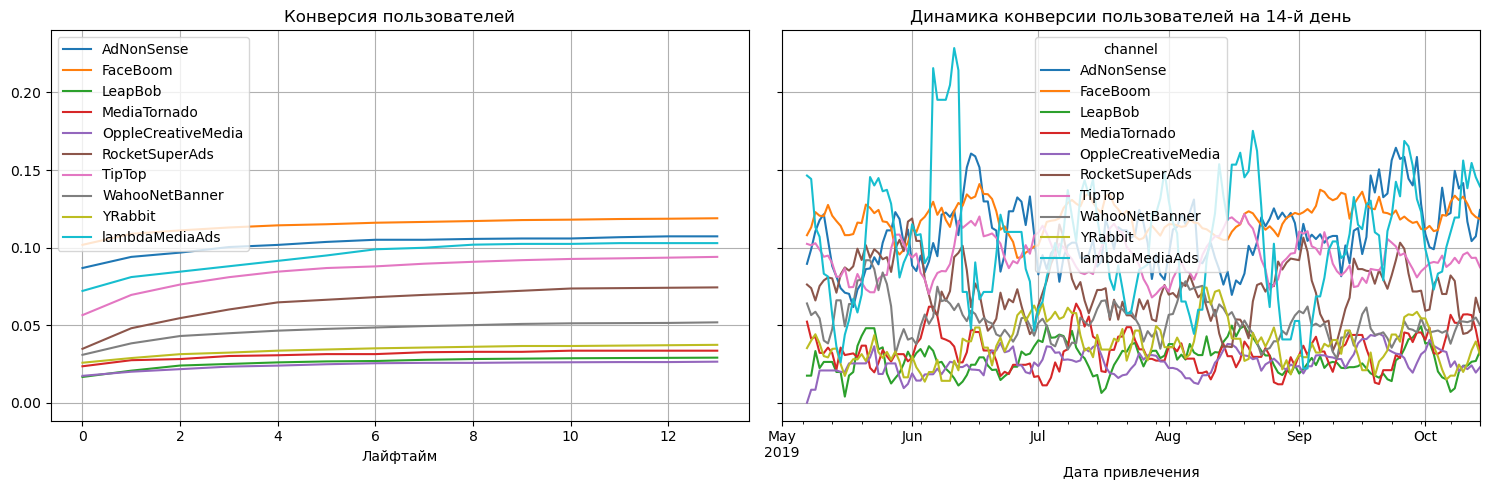

In [44]:
#Смотрим конверсию по каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Канал TipTop показывает весьма средную конверсию. У площадки FaceBoom мы видим хороший показатель, а также у lambdaMediaAds, особенно в динамике.

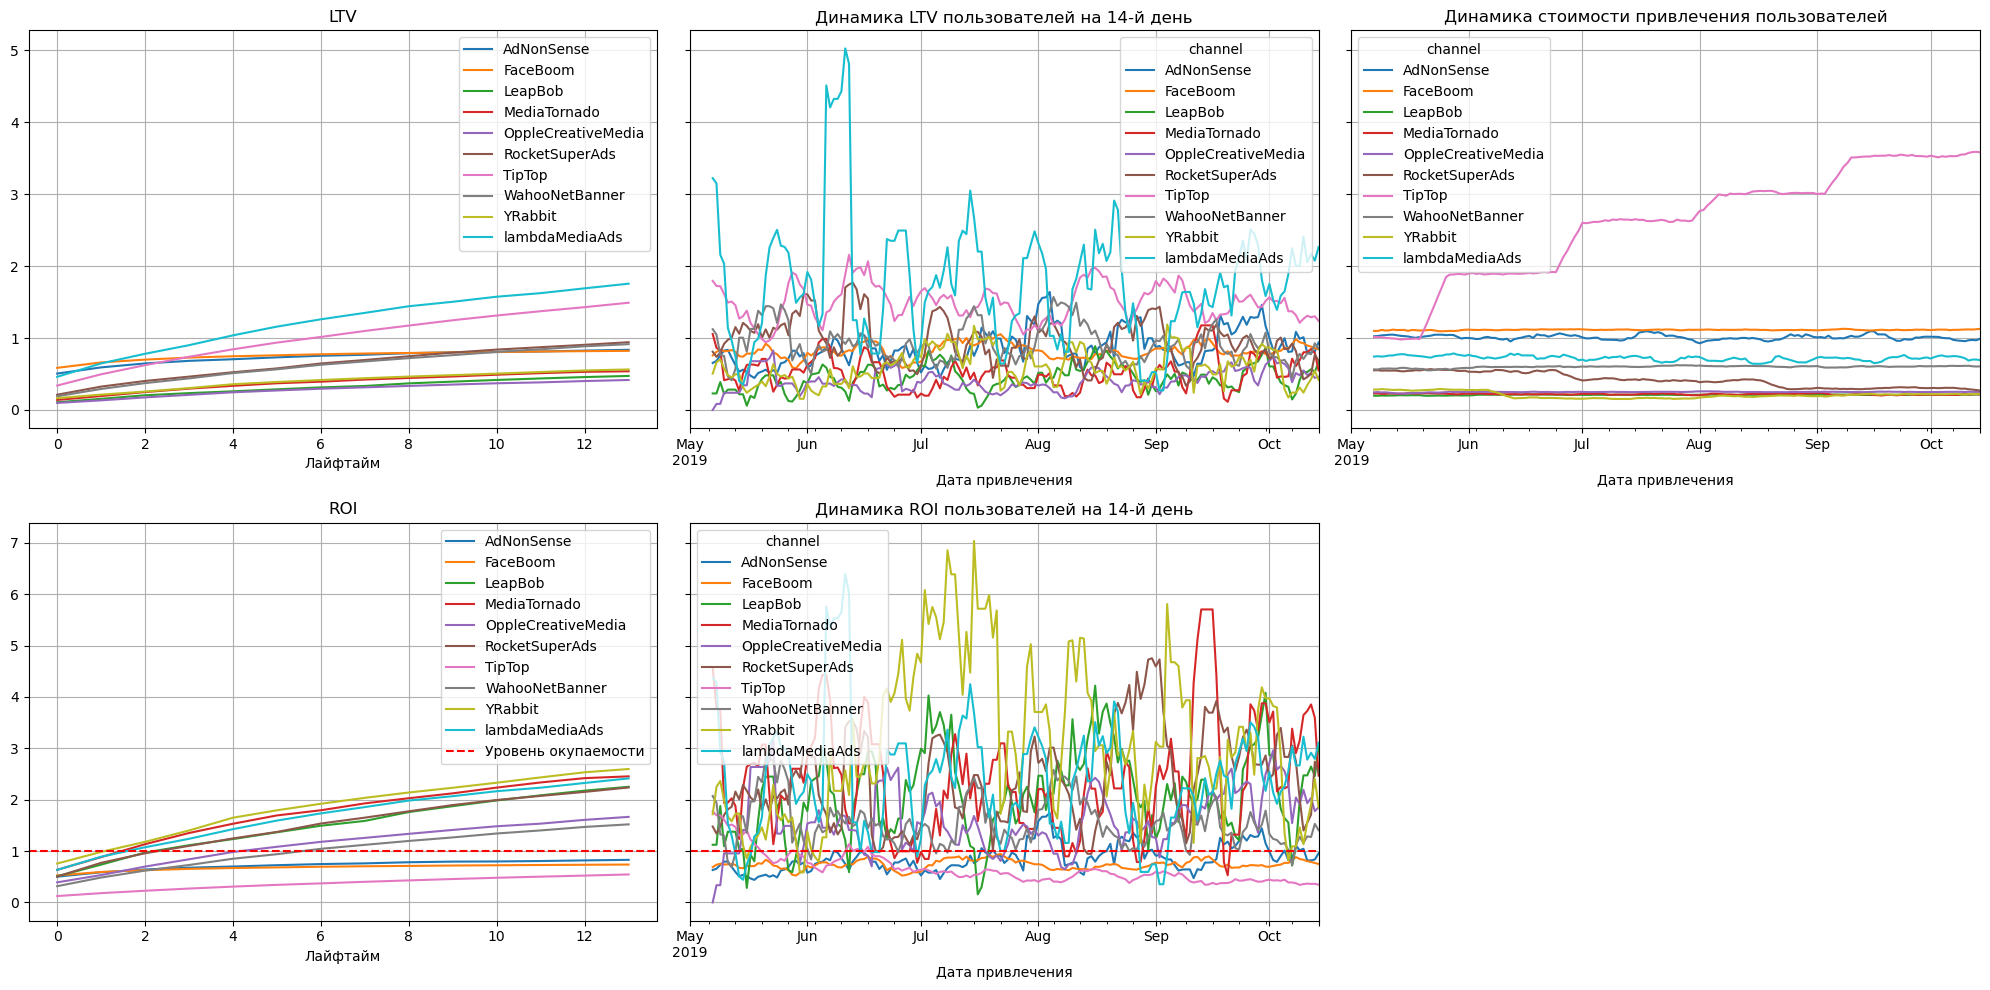

In [45]:
# смотрим окупаемость с разбивкой по рекламным каналам
dimensions = ['channel']

# считаем LTV, ROI и САС с разбивкой по рекламным каналам.
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Уже с июня при распределении рекламного бюджета предпочтение отдавали площадке TipTop, но площадка по всем параментам показывает только минус. Убыточными остаются: TipTop, FaceBoom, AdNonSense. 
Хорошую окупаемость в июле и августе показала площадка YRabbit. Также стоит присмотреться к площадке LambdaMediaAds - весьма хорошие показатели.

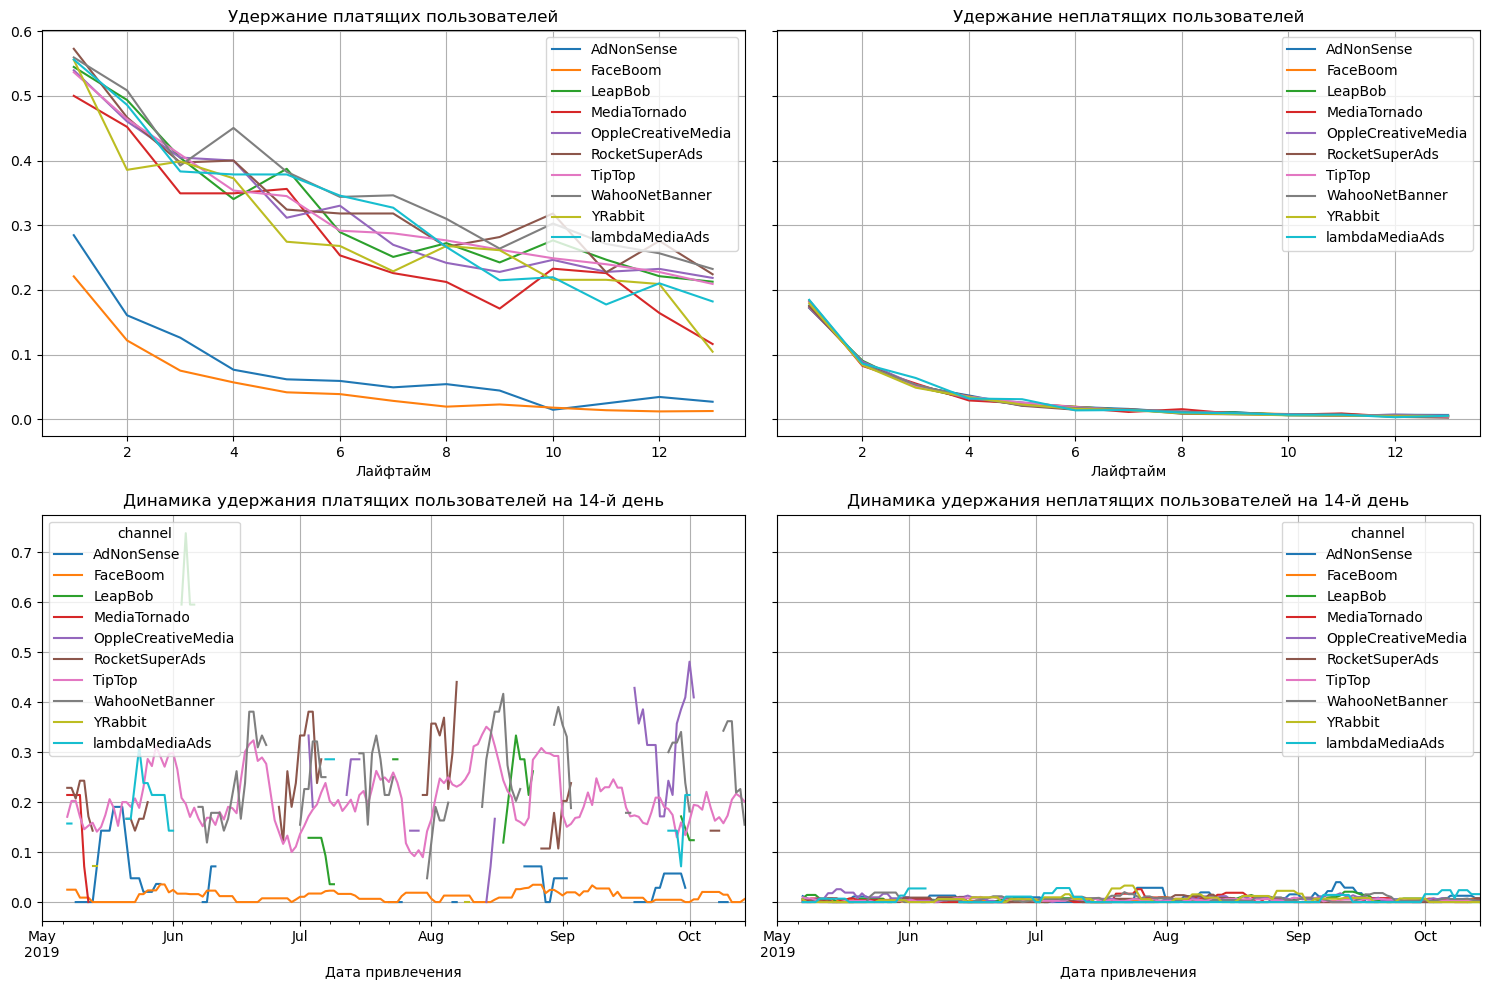

In [46]:
# смотрим удержание с разбивкой по каналам
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

У платформ FaceBoom, AdNonSense очень плохое удержание клиентов. Прочие платформы показывают схожие между собой результаты. 

#### Вывод

В целом реклама не окупается. В данный момент негативное влияние на окупаемость показывают устройства Apple, и рекламный канал TipTop и FaceBoom. Следует более делатьно изучить пользователей из США, так как они показывают высокую вовлеченность, а так же сам охват очень большой, но в отношении очень большого рекламного бюджета - не окупаются. 
По иследованию видно, что изменения произошли с июня месяца. В том числе перераспределение бюджета. Следует отказаться от рекламы на площадке TipTop и посмотреть в сторону LambdaMediaAds.

### Общие выводы

Мы изучили эффективность рекламной компании в период с 1 мая по 27 октября 2019 года. 

Рекламный бюджет составил 105497.3. 

Из них распределенно на площадки:
<table>
  <tr>
    <th>Площадка</th>
    <th>Бюджет</th> 
    <th>Конверсия</th>
    <th>Удержание</th>
    <th>Реклама окупилась</th>
    <th>Вовлеченность клиента</th>
    <th>Стоимость клиента</th>
  </tr>
  <tr>
    <td> TipTop</td>
    <td>54751.30</td>
    <td>средняя</td>
    <td>хорошее</td>
    <td>нет</td>  
    <td>хорошая</td>
    <td>2.8</td>
  </tr>
  <tr>
    <td>FaceBoom</td>
    <td>32445.60</td>
    <td>высокая</td> 
    <td>низкое</td>
    <td>нет</td>
    <td>не высокая</td>
    <td>1.2</td>  
  </tr>
  <tr>
    <td>WahooNetBanner</td>
    <td>5151.00</td>
    <td>низкая</td>
    <td>высокое</td>  
    <td>да</td>
    <td>достаточная</td>
    <td>0.6</td>  
  </tr>
   <tr>
    <td>AdNonSense</td>
    <td>3911.25</td>
    <td>хорошая</td> 
    <td>очень низкое</td>
    <td>нет</td>
    <td>не высокая</td>
    <td>1.01</td>  
  </tr>  
   <tr>
    <td>OppleCreativeMedia</td>
    <td>2151.25</td>
    <td>очень низкая</td>
    <td>среднее</td>   
    <td>да</td>
    <td>низкая</td>
    <td>0.25</td>  
  </tr> 
    <tr>
    <td>lambdaMediaAds</td>
    <td>1557.60</td>
    <td>хорошая</td>
    <td>высокое</td>    
    <td>да</td>
    <td>высокая</td>
    <td>0.72</td>  
  </tr> 
</table>
Прочие площадки в итоговую таблицу не включили, так как на них было выделенно менее 5% от общего бюджета.

83% рекламного бюджета было направлено на площадки, где стоимость одного клиента очень высока, а реклама не окупается. И если TipTop при среднем показателе конверсии имеет хорошее удержание, то FaceBoom при высокой конверсии очень плохо удерживает клиента. 

Следует обратить внимание на площадку lambdaMediaAds: она показывает хорошую конверсию, высокое удержание, высокую окупаемость и высокую вовлеченность пользователей, при хорошей стоимости клиента.

Изучили с каких устройств чаще происходят покупки. Покупки через РС единственные оказались с положительным ROI и то лишь до сентября месяца.
Пользователей Mac и iPhone на 22% больше, чем пользователей РС и Android, и конверцию они показываю выше, однако по окупаемости и удержанию клиентов сильно проигрывают. Возможно следует изучить какие ошибки встречаются пользователям, а также проверить корректно ли работает приложение на iOs и через браузер Safari.

Исследование по регионам нам показало, что рынок сосредоточен на США, ведь они показывают высокую конверсию, но вместе с тем весьма низкое удержание - мы это связывает с таким же низким урежание с устройств Mac и iphone (на США приходится 80% пользователей данных устройств). Также по графикам видим хороший потенциал в европейских странам: Германия, Франция, UK.

Проведя исследование можно сказать, что рекламные компании были распланированы исходя их показателей конверсии, но изучив данные по окупаемости и удержании очевидно, что курс был задан не совсем верно.

Рекомендуем: 
- перераспределить бюджет. Обратить внимание на площадки: lambdaMediaAds, WahooNetBanner.
- проверить корректность работы приложения на Mac и iPhone
- более активно расширить рынок на Германию, Францию, Великобританию.
